# Exploratory Data Analysis

In [10]:
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Pyspark modules
from pyspark.sql import SparkSession
from pyspark import sql, SparkContext, SparkConf
import pyspark.sql.functions as F

In [11]:
# Create spark session
spark = SparkSession.builder.appName("project").getOrCreate()

# Load data 

In [45]:
df = spark.read.csv('../data/hmeq.csv', inferSchema = True, header = True)  # load data

df = df.toDF(*[c.lower() for c in df.columns]) # column names in lower case

df.createOrReplaceTempView("raw_table") # create table for sql query

print("Data size:", (df.count(), len(df.columns))) # print data size
df.show()

Data size: (5960, 13)
+---+----+--------+--------+-------+------+----+-----+------+------------+----+----+------------+
|bad|loan| mortdue|   value| reason|   job| yoj|derog|delinq|       clage|ninq|clno|     debtinc|
+---+----+--------+--------+-------+------+----+-----+------+------------+----+----+------------+
|  1|1100| 25860.0| 39025.0|HomeImp| Other|10.5|    0|     0|94.366666667|   1|   9|        null|
|  1|1300| 70053.0| 68400.0|HomeImp| Other| 7.0|    0|     2|121.83333333|   0|  14|        null|
|  1|1500| 13500.0| 16700.0|HomeImp| Other| 4.0|    0|     0|149.46666667|   1|  10|        null|
|  1|1500|    null|    null|   null|  null|null| null|  null|        null|null|null|        null|
|  0|1700| 97800.0|112000.0|HomeImp|Office| 3.0|    0|     0|93.333333333|   0|  14|        null|
|  1|1700| 30548.0| 40320.0|HomeImp| Other| 9.0|    0|     0|101.46600191|   1|   8|37.113613558|
|  1|1800| 48649.0| 57037.0|HomeImp| Other| 5.0|    3|     2|        77.1|   1|  17|        null

# Data types and missing values

The data shows that there are two categorical variables and some variables have missing values

In [74]:
df.printSchema()

root
 |-- bad: integer (nullable = true)
 |-- loan: integer (nullable = true)
 |-- mortdue: double (nullable = true)
 |-- value: double (nullable = true)
 |-- reason: string (nullable = true)
 |-- job: string (nullable = true)
 |-- yoj: double (nullable = true)
 |-- derog: integer (nullable = true)
 |-- delinq: integer (nullable = true)
 |-- clage: double (nullable = true)
 |-- ninq: integer (nullable = true)
 |-- clno: integer (nullable = true)
 |-- debtinc: double (nullable = true)



In [55]:
df.agg(*[F.count(c).alias(c) for c in df.columns]).show()

+----+----+-------+-----+------+----+----+-----+------+-----+----+----+-------+
| bad|loan|mortdue|value|reason| job| yoj|derog|delinq|clage|ninq|clno|debtinc|
+----+----+-------+-----+------+----+----+-----+------+-----+----+----+-------+
|5960|5960|   5442| 5848|  5708|5681|5445| 5252|  5380| 5652|5450|5738|   4693|
+----+----+-------+-----+------+----+----+-----+------+-----+----+----+-------+



# Count missing values

In [66]:
df.agg(*(F.sum(F.col(c).isNull().cast("int"))\
            .alias(c) for c in df.columns)
         ).show()

+---+----+-------+-----+------+---+---+-----+------+-----+----+----+-------+
|bad|loan|mortdue|value|reason|job|yoj|derog|delinq|clage|ninq|clno|debtinc|
+---+----+-------+-----+------+---+---+-----+------+-----+----+----+-------+
|  0|   0|    518|  112|   252|279|515|  708|   580|  308| 510| 222|   1267|
+---+----+-------+-----+------+---+---+-----+------+-----+----+----+-------+



# Categorical variables

In [28]:
df.groupBy('job').count().show()

+-------+-----+
|    job|count|
+-------+-----+
|  Sales|  109|
| Office|  948|
|ProfExe| 1276|
|   null|  279|
|   Self|  193|
|  Other| 2388|
|    Mgr|  767|
+-------+-----+



In [29]:
df.groupBy('reason').count().show()

+-------+-----+
| reason|count|
+-------+-----+
|HomeImp| 1780|
|   null|  252|
|DebtCon| 3928|
+-------+-----+



# Class distribution

In [48]:
query = """ 
select 
    bad, 
    count(*) as count,
    count(*)*100/(select count(*) from raw_table) as percentage
from raw_table
group by 1
"""
spark.sql(query).show()

+---+-----+------------------+
|bad|count|        percentage|
+---+-----+------------------+
|  1| 1189|19.949664429530202|
|  0| 4771|  80.0503355704698|
+---+-----+------------------+



# Statistical description

In [72]:
df.select('loan', 'mortdue', 'yoj', 'derog', 'value').describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+
|summary|              loan|           mortdue|              yoj|             derog|             value|
+-------+------------------+------------------+-----------------+------------------+------------------+
|  count|              5960|              5442|             5445|              5252|              5848|
|   mean| 18607.96979865772| 73760.81719955898|8.922268135904508|0.2545696877380046|101776.04874145007|
| stddev|11207.480416693992|44457.609458415885|7.573982248898881| 0.846046777086318|  57385.7753337027|
|    min|              1100|            2063.0|              0.0|                 0|            8000.0|
|    max|             89900|          399550.0|             41.0|                10|          855909.0|
+-------+------------------+------------------+-----------------+------------------+------------------+



In [30]:
# Pandas dataframe
pdf = df.toPandas()

# Predictors' Correlation
The correlation matrix shows slightly high correlation between value and mortdue

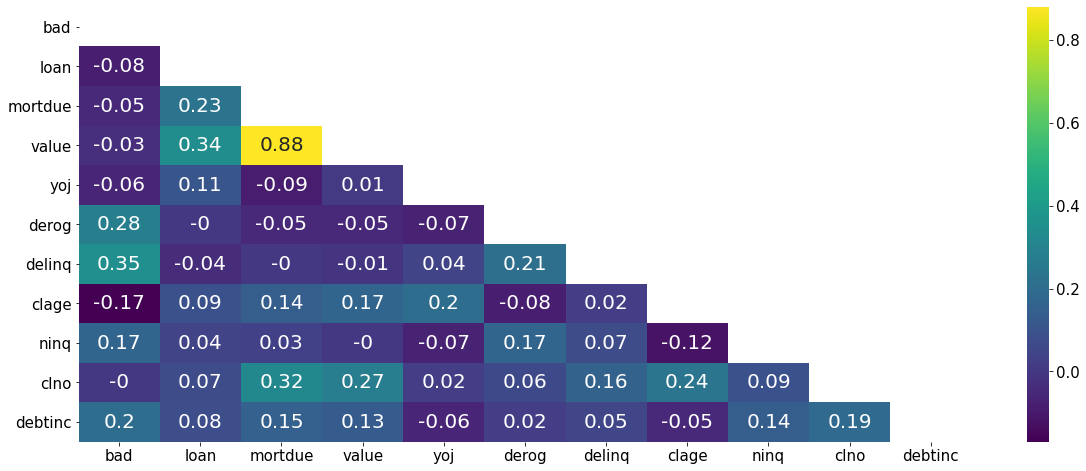

In [21]:
fig, ax = plt.subplots(figsize=(20,8))

# Correlation matrix
corr_matrix = pdf.corr()

# Plot
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(round(corr_matrix, 2), annot=True, annot_kws={"size": 20},mask = mask, 
            cmap = plt.get_cmap("viridis"),ax = ax)
plt.show()

# Histogram
The histogram distribution shows that the nnumerical variables are right screwed due to outliers. This suggest log(1+x) transformation during modeling

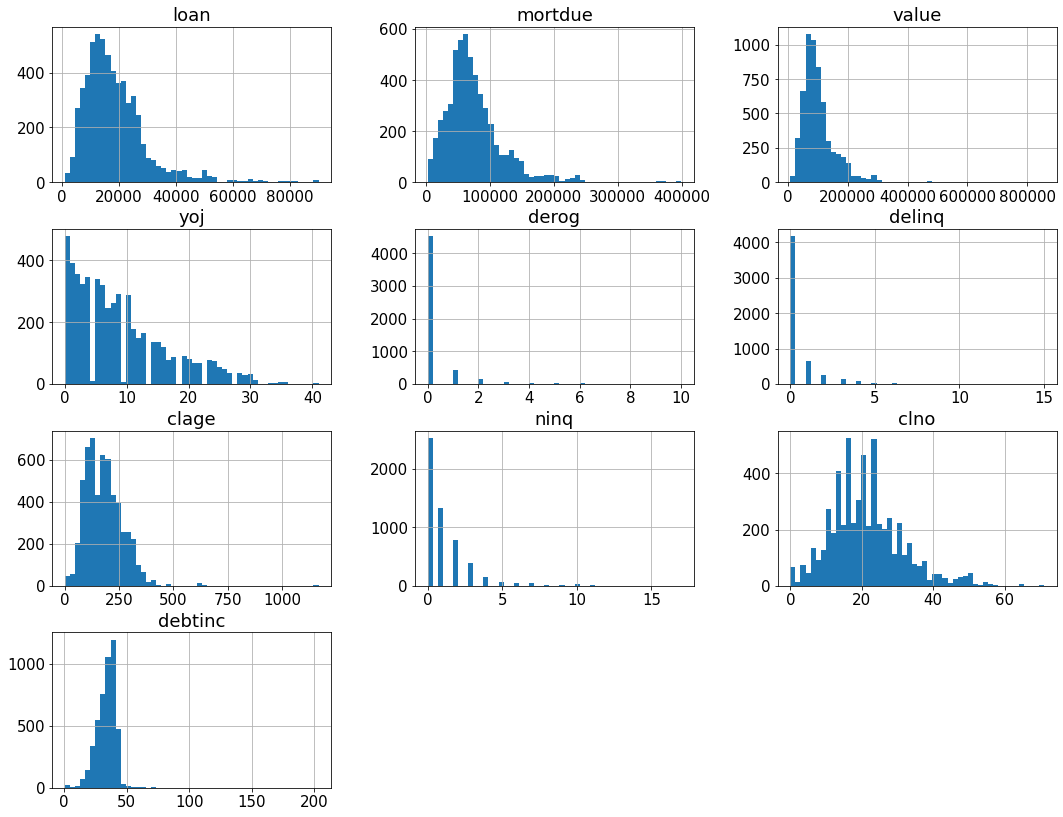

In [22]:
pdf.drop('bad', axis = 1).hist(bins = 50, figsize = (18,14))
plt.show()

# Default rate by number of credit lines

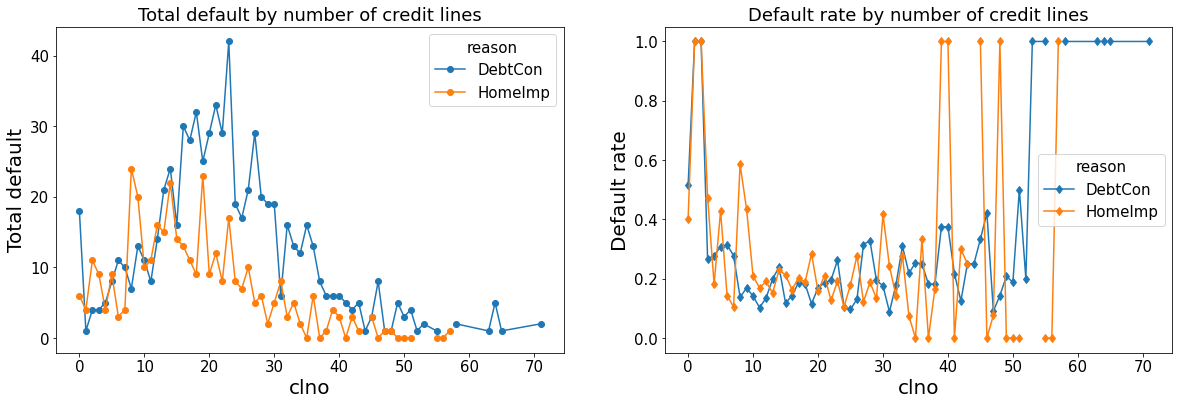

In [23]:
# set figure
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,6))

# pivot table
pivot_tab_1 = pdf.pivot_table('bad', index = 'clno', columns = 'reason', aggfunc = 'sum')
pivot_tab_2 = pdf.pivot_table('bad', index = 'clno', columns = 'reason', aggfunc = 'mean')

# plots
pivot_tab_1.plot(marker = 'o', ax = ax1)
pivot_tab_2.plot(marker = 'd', ax = ax2)

ax1.set_xlabel('clno', fontsize = 20)
ax1.set_ylabel('Total default', fontsize = 20)
ax1.set_title('Total default by number of credit lines')
ax2.set_xlabel('clno', fontsize = 20)
ax2.set_ylabel('Default rate', fontsize = 20)
ax2.set_title('Default rate by number of credit lines')
plt.savefig('../images/fig1.png')

# Default rate by number of recent credit inquiries & major derogatory reports

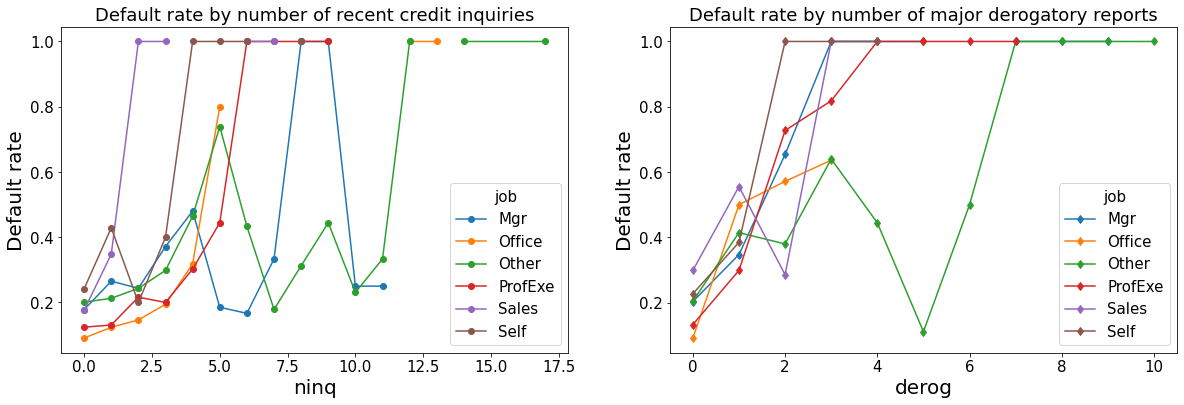

In [24]:
# set figure
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,6))

# pivot table
pivot_tab_1 = pdf.pivot_table('bad', index = 'ninq', columns = 'job', aggfunc = 'mean')
pivot_tab_2 = pdf.pivot_table('bad', index = 'derog', columns = 'job', aggfunc = 'mean')

# plots
pivot_tab_1.plot(marker = 'o', ax = ax1)
pivot_tab_2.plot(marker = 'd', ax = ax2)

ax1.set_xlabel('ninq', fontsize = 20)
ax1.set_ylabel('Default rate', fontsize = 20)
ax1.set_title('Default rate by number of recent credit inquiries')
ax2.set_xlabel('derog', fontsize = 20)
ax2.set_ylabel('Default rate', fontsize = 20)
ax2.set_title('Default rate by number of major derogatory reports')
plt.savefig('../images/fig2.png')

# Default rate by job description

Text(0.5, 1.0, 'Default rate by reason')

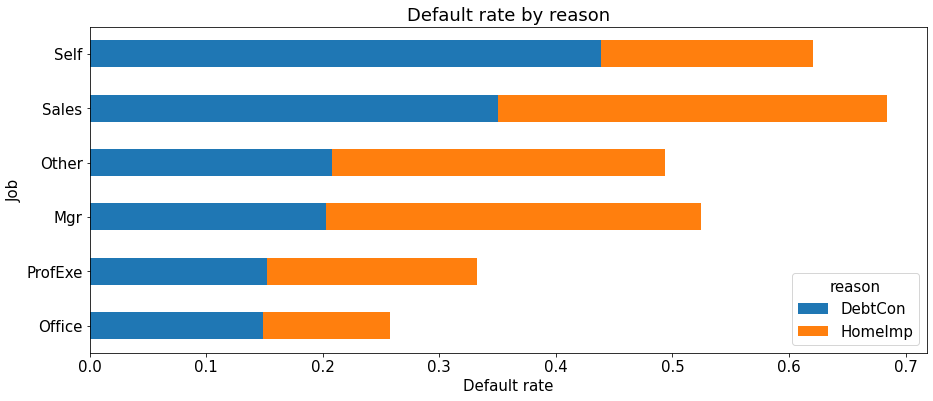

In [25]:
# pivot table and plot
pvt = pdf.pivot_table('bad', index = 'job', columns = 'reason', aggfunc = 'mean')
pvt.sort_values(by = ['DebtCon', 'HomeImp']).plot(kind = 'barh', stacked = True, figsize = (15,6))

plt.xlabel('Default rate')
plt.ylabel('Job')
plt.title('Default rate by reason')